In [1]:
#####ベイジアン多変量回帰モデル#####
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy
import scipy.linalg
import scipy.stats as ss
import seaborn as sns
from numpy.random import *
from scipy import optimize
from scipy.stats import norm
from scipy import sparse

In [2]:
####任意の相関行列(分散共分散行列)を作成する関数####
##任意の相関行列を作る関数
def CorM(col, lower, upper, eigen_lower, eigen_upper):
    #相関行列の初期値を定義する
    cov_vec = (upper - lower) *rand(col*col) + lower   #相関係数の乱数ベクトルを作成
    rho = np.reshape(np.array(cov_vec), (col, col)) * np.tri(col)   #乱数ベクトルを下三角行列化
    Sigma = np.diag(np.diag(rho + rho.T) + 1) - (rho + rho.T)   #対角成分を1にする
    
    #相関行列を正定値行列に変更
    #固有値分解を実行
    eigen = scipy.linalg.eigh(Sigma)
    eigen_val = eigen[0] 
    eigen_vec = eigen[1]
    
    #固有値が負の数値を正にする
    for i in range(eigen_val.shape[0]-1):
        if eigen_val[i] < 0:
            eigen_val[i] = (eigen_upper - eigen_lower) * rand(1) + eigen_lower
            
    #新しい相関行列の定義と対角成分を1にする
    Sigma = np.dot(np.dot(eigen_vec, np.diag(eigen_val)), eigen_vec.T)
    normalization_factor = np.dot(pow(np.diag(Sigma), 0.5)[:, np.newaxis], pow(np.diag(Sigma), 0.5)[np.newaxis, :])
    Cor = Sigma / normalization_factor
    return Cor

In [3]:
##相関行列から分散共分散行列に変換する関数
def covmatrix(Cor, sigma_lower, sigma_upper):
    sigma = (sigma_upper - sigma_lower) * rand(np.diag(Cor).shape[0]) + sigma_lower
    sigma_factor = np.dot(sigma[:, np.newaxis], sigma[np.newaxis, :])
    Cov = Cor * sigma_factor
    return Cov

In [4]:
####データの発生####
#データの設定
n = 100000   #サンプル数
k = 6   #応答変数数

##任意の分散共分散行列を発生させる
#パラメータを設定
col = 10
lower = -0.9
upper = 0.9
eigen_lower = 0
eigen_upper = 0.1
sigma_lower = 1.5
sigma_upper = 2.0

#相関行列を発生させる
Cor = CorM(col=col, lower=lower, upper=upper, eigen_lower=eigen_lower, eigen_upper=eigen_upper)
print(scipy.linalg.eigh(Cor)[0])   #正定値かどうか確認
print(np.round(Cor, 3))   #相関行列を確認

#分散共分散行列に変換
Cov = covmatrix(Cor=Cor, sigma_lower=sigma_lower, sigma_upper=sigma_upper)
print(scipy.linalg.eigh(Cov)[0])
print(np.round(Cov, 3))


##説明変数の発生
#連続変数の発生
cont = 8
X_cont = randn(n, cont)

#二値変数の発生
bin = 10
X_bin = np.zeros((n, bin))

for i in range(X_bin.shape[1]):
    p_bin = (0.7 - 0.4) * rand() + 0.4
    X_bin[:, i] = binomial(1, p_bin, n)

#多値変数の発生
multi = 8
p_multi = np.random.dirichlet(np.repeat(1.0, multi))
X_multi = multinomial(1, p_multi, n)

multi_sums = np.sum(X_multi, axis=0)
X_multi = np.delete(X_multi, multi_sums.argmin(), axis=1)   #冗長な変数を削除

#説明変数を結合
intercept = np.ones((n, 1))
X = np.concatenate((intercept, X_cont, X_bin, X_multi), axis=1)
col = X.shape[1]

[0.01617265 0.05113654 0.07060041 0.11757102 0.78717932 1.13228357
 1.32039644 1.74688811 2.0157094  2.74206255]
[[ 1.     0.08   0.277 -0.018  0.365 -0.537  0.46   0.048  0.299  0.168]
 [ 0.08   1.    -0.321 -0.086 -0.233  0.474  0.142  0.036  0.126  0.168]
 [ 0.277 -0.321  1.    -0.222  0.545 -0.551 -0.123  0.257 -0.452 -0.01 ]
 [-0.018 -0.086 -0.222  1.     0.425  0.271  0.39  -0.286 -0.417  0.287]
 [ 0.365 -0.233  0.545  0.425  1.    -0.343  0.001  0.284 -0.43   0.513]
 [-0.537  0.474 -0.551  0.271 -0.343  1.     0.065  0.119  0.017 -0.218]
 [ 0.46   0.142 -0.123  0.39   0.001  0.065  1.    -0.221  0.175 -0.388]
 [ 0.048  0.036  0.257 -0.286  0.284  0.119 -0.221  1.     0.297 -0.125]
 [ 0.299  0.126 -0.452 -0.417 -0.43   0.017  0.175  0.297  1.    -0.365]
 [ 0.168  0.168 -0.01   0.287  0.513 -0.218 -0.388 -0.125 -0.365  1.   ]]
[0.04966663 0.1637159  0.20140149 0.32199385 2.64614373 3.47308791
 4.53833982 4.78939764 6.44804454 8.30524758]
[[ 2.442e+00  2.470e-01  7.420e-01 -5.100e-

[[ 1.    -0.005  0.027  0.158  0.011  0.249]
 [-0.005  1.     0.342  0.088  0.009 -0.313]
 [ 0.027  0.342  1.    -0.401 -0.131 -0.368]
 [ 0.158  0.088 -0.401  1.    -0.046 -0.398]
 [ 0.011  0.009 -0.131 -0.046  1.    -0.43 ]
 [ 0.249 -0.313 -0.368 -0.398 -0.43   1.   ]]
[[ 4.645 -0.016  0.118  0.536  0.054  0.988]
 [-0.016  2.394  1.095  0.214  0.03  -0.892]
 [ 0.118  1.095  4.29  -1.307 -0.597 -1.405]
 [ 0.536  0.214 -1.307  2.477 -0.158 -1.154]
 [ 0.054  0.03  -0.597 -0.158  4.833 -1.745]
 [ 0.988 -0.892 -1.405 -1.154 -1.745  3.401]]
[ 3.12124281  1.46707385  2.9658576  ...  2.99492038 -0.42213438
  2.15203947]


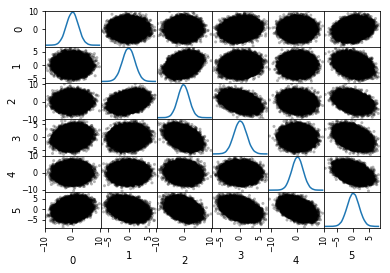

In [5]:
##応答変数の発生
#回帰パラメータの発生
BETA = np.zeros([X.shape[1], k])

for i in range(BETA.shape[1]):
    beta01 = uniform(1.5, 3.0, 1)
    beta02 = uniform(0, 1.0, cont)
    beta03 = uniform(-1.2, 1.6, (bin+multi-1))
    BETA[:, i] = np.concatenate((beta01, beta02, beta03), axis=0).T
BETAT = BETA

#分散共分散行列の発生
lower = -0.75
upper = 0.9
eigen_lower = 0
eigen_upper = 0.1
sigma_lower = 1.5
sigma_upper = 2.2

#相関行列を発生させる
Cor = CorM(col=k, lower=lower, upper=upper, eigen_lower=eigen_lower, eigen_upper=eigen_upper)
print(np.round(Cor, 3))   #相関行列を確認

#分散共分散行列に変換
Cov = covmatrix(Cor=Cor, sigma_lower=sigma_lower, sigma_upper=sigma_upper)
Covt = Cov
print(np.round(Cov, 3))

#回帰モデルの平均構造を設定
Z = np.dot(X, BETA)

#平均構造に多変量正規分布の誤差を加える
Y = np.zeros((n, k))

for i in range(Y.shape[0]):
    Y[i, ] = np.random.multivariate_normal(Z[i, :], Cov)

#発生させた応答変数の集計
print(np.average(Y, axis=1))
#print(np.corrcoef(Y))

#scatter_matrix(pd.DataFrame(Y), diagonal="kde", color="k", alpha=0.3)
er_pd = pd.DataFrame(Y - Z)
pd.plotting.scatter_matrix(er_pd, diagonal='kde', color='k', alpha=0.3)
plt.show()

In [6]:
#####ギブスサンプリングで多変量回帰モデルを推定#####
##多変量正規分布の密度関数
def dmv(x, mu, Cov, k):
    er = x - mu
    Cov_inv = np.linalg.inv(Cov) 
    LLo = 1 / (np.sqrt(pow((2 * np.pi), k) * np.linalg.det(Cov))) * np.exp(-1/2 * np.dot(np.dot(er, Cov_inv) *er, np.ones(k)))
    return(LLo)

In [7]:
##アルゴリズムの設定
LL1 = -100000000   #対数尤度の初期値
R = 10000   #サンプリング回数
keep = 4   #4回に1回の割合でサンプリング結果を保存
disp = 200
sbeta = 1.5

In [8]:
##事前分布の設定
Deltabar = np.zeros((col, k))
ADelta = 0.01 * np.diag(np.ones(col))
nu = k + 1
V = nu * np.diag(np.ones(k))

In [9]:
##初期値の設定
beta = np.zeros((col, k))
Cov = np.diag(np.ones(k))
np.sum(np.log(dmv(Y, np.dot(X, beta), Cov, k)))   #初期値での対数尤度

-5388910.303169464

In [10]:
##定数の設定
XX = np.dot(X.T, X)
XY = np.dot(X.T, Y)
inv_XXV = np.linalg.inv(np.dot(X.T, X) + ADelta)

In [11]:
##パラメータの格納用配列
BETA = np.zeros((col, k, int(R/keep)))
COV = np.zeros((k, k, int(R/keep)))
LL = np.zeros((int(R/keep)))

In [12]:
##対数尤度の基準値
#1パラメータモデルの対数尤度
mu = np.repeat(np.mean(Y, axis=0), n).reshape(n, k, order="F")
LLst = np.sum(np.log(dmv(Y, mu, np.dot((Y-mu).T, Y-mu) / n, k)))

#真値での対数尤度
LLbest = np.sum(np.log(dmv(Y, np.dot(X, BETAT), Covt, k)))

In [13]:
####ギブスサンプラーでパラメータをサンプリング####
for rp in range(R):
    ##多変量正規分布から回帰行列をサンプリング
    #事後分布のパラメータを設定
    beta_mu = np.dot(inv_XXV, XY + np.dot(ADelta, Deltabar)).T.reshape(-1)   #平均ベクトル
    sigma = np.kron(Cov, inv_XXV)   #分散共分散行列

    #パラメータをサンプリング
    beta_vec = np.random.multivariate_normal(beta_mu, sigma, 1)
    beta = beta_vec.reshape(col, k, order='F')   #回帰行列に変換

    
    ##逆ウィシャート分布から分散共分散行列をサンプリング
    #モデル誤差を設定
    mu = np.dot(X, beta)
    er = Y - mu

    #逆ウィシャート分布のパラメータ
    IW_R = np.dot(er.T, er) + V
    Sn = n + nu

    #パラメータをサンプリング
    Cov = scipy.stats.invwishart.rvs(Sn, IW_R, 1)

    
    ##パラメータの格納とサンプリング結果の表示
    #サンプリング結果の格納
    if rp%keep==0:
        mkeep = rp//keep
        BETA[:, :, mkeep] = beta
        COV[:, :, mkeep] = Cov

    if rp%disp==0:
        #対数尤度の更新
        LL = np.sum(np.log(dmv(Y, mu, Cov, k)))

        #サンプリング結果を確認
        print(rp)
        print(np.round(np.array([LL, LLst, LLbest]), 1))

0
[-1058525.7 -1426283.7 -1058314.4]
200
[-1058310.4 -1426283.7 -1058314.4]
400
[-1058323.6 -1426283.7 -1058314.4]
600
[-1058317.3 -1426283.7 -1058314.4]
800
[-1058320.9 -1426283.7 -1058314.4]
1000
[-1058310.5 -1426283.7 -1058314.4]
1200
[-1058320.6 -1426283.7 -1058314.4]
1400
[-1058306.2 -1426283.7 -1058314.4]
1600
[-1058307.8 -1426283.7 -1058314.4]
1800
[-1058322.4 -1426283.7 -1058314.4]
2000
[-1058305.2 -1426283.7 -1058314.4]
2200
[-1058311.9 -1426283.7 -1058314.4]
2400
[-1058300.5 -1426283.7 -1058314.4]
2600
[-1058311.5 -1426283.7 -1058314.4]
2800
[-1058306.4 -1426283.7 -1058314.4]
3000
[-1058295.5 -1426283.7 -1058314.4]
3200
[-1058311.8 -1426283.7 -1058314.4]
3400
[-1058309.8 -1426283.7 -1058314.4]
3600
[-1058315.2 -1426283.7 -1058314.4]
3800
[-1058313.3 -1426283.7 -1058314.4]
4000
[-1058303.4 -1426283.7 -1058314.4]
4200
[-1058317.2 -1426283.7 -1058314.4]
4400
[-1058320.  -1426283.7 -1058314.4]
4600
[-1058309.8 -1426283.7 -1058314.4]
4800
[-1058309.8 -1426283.7 -1058314.4]
5000
[-